In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


In [74]:
retail = pd.read_csv('frfr.csv')
retail.head()

,OrderID,CustomerID,Amount,Created_at
0,9606727,35000.0,925.0,2020-01-01 18:56
1,9606913,2709788.0,1545.0,2020-01-01 22:11
2,9607094,19212.0,1950.0,2020-01-02 08:04
3,9607144,1694062.0,603.0,2020-01-02 08:32
4,9607241,2156661.0,1090.0,2020-01-02 09:04


In [75]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   OrderID     100000 non-null  object 
 1   CustomerID  99998 non-null   float64
 2   Amount      99998 non-null   float64
 3   Created_at  99998 non-null   object 
dtypes: float64(2), object(2)
memory usage: 3.1+ MB


In [76]:
# df description

retail.describe()

,CustomerID,Amount
count,9.999800e+04,99998.000000
mean,1.675082e+06,979.598227
std,8.919875e+05,557.162270
min,2.254000e+03,0.000000
25%,9.301530e+05,594.000000
50%,1.790523e+06,900.000000
75%,2.498435e+06,1190.000000
max,3.471076e+06,12922.000000


## Шаг 2 : Очистка данных
Расчет недостающих значений в процентном соотношении  в DF

In [77]:


df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

OrderID       0.0
CustomerID    0.0
Amount        0.0
Created_at    0.0
dtype: float64

In [78]:
# Очистка от строк с пропущенными значениями 

retail = retail.dropna()
retail.shape

(99998, 4)

In [79]:
# Изменение типа данных для ID Клиента 
retail['CustomerID'] = retail['CustomerID'].astype(str)

## Шаг 3: Подготовка данных

Мы собираемся анализировать клиентов на основе следующих трех факторов:
- R (Recency) количество дней с момента последней покупки клиента.
- F (Frequency): количество заказов клиента.
- M (Monetary): общая сумма транзакций клента.

In [80]:


# Добавим новый атрибут : Monetary

# retail['Amount'] = retail['cash_price']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,1000037.0,1600.0
1,1000052.0,4010.0
2,100008.0,3994.0
3,1000093.0,645.0
4,1000143.0,5849.0


In [81]:
# Добавим новый атрибут : Frequency

rfm_f = retail.groupby('CustomerID')['OrderID'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,1000037.0,2
1,1000052.0,3
2,100008.0,5
3,1000093.0,1
4,1000143.0,5


In [82]:
# Объединим две таблиы данных

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,1000037.0,1600.0,2
1,1000052.0,4010.0,3
2,100008.0,3994.0,5
3,1000093.0,645.0,1
4,1000143.0,5849.0,5


In [83]:
# Добавим новый атрибут : Recency

# Сделаем конвертацию даты в нужный формат для дальнейшей работы

retail['Created_at'] = pd.to_datetime(retail['Created_at'],format='%Y-%m-%d %H:%M')

In [84]:
# Вычислим время самой последней транзакции для каждого клиента

max_date = max(retail['Created_at'])
max_date

Timestamp('2020-04-10 17:01:00')

In [85]:
# Вычислим для всех заказов разницу между временем создания заказа и временем создания последнего заказа

retail['Diff'] = max_date - retail['Created_at']
retail.head()

,OrderID,CustomerID,Amount,Created_at,Diff
0,9606727,35000.0,925.0,2020-01-01 18:56:00,99 days 22:05:00
1,9606913,2709788.0,1545.0,2020-01-01 22:11:00,99 days 18:50:00
2,9607094,19212.0,1950.0,2020-01-02 08:04:00,99 days 08:57:00
3,9607144,1694062.0,603.0,2020-01-02 08:32:00,99 days 08:29:00
4,9607241,2156661.0,1090.0,2020-01-02 09:04:00,99 days 07:57:00


In [86]:
#  Вычислим Recency, "давность оформления заказа" для каждого клиента

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()


,CustomerID,Diff
0,1000037.0,7 days 00:12:00
1,1000052.0,2 days 04:58:00
2,100008.0,0 days 01:48:00
3,1000093.0,86 days 23:48:00
4,1000143.0,5 days 02:35:00


In [87]:
# Посчитаем в днях

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,1000037.0,7
1,1000052.0,2
2,100008.0,0
3,1000093.0,86
4,1000143.0,5


In [88]:
# Объединим таблицы в целое, получим RFM таблицу
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,1000037.0,1600.0,2,7
1,1000052.0,4010.0,3,2
2,100008.0,3994.0,5,0
3,1000093.0,645.0,1,86
4,1000143.0,5849.0,5,5


### Есть 2 типа выбросов, которые мы будем обрабатывать:
- Статистический
- Зависящий от домена


Text(0.5, 0, 'Attributes')

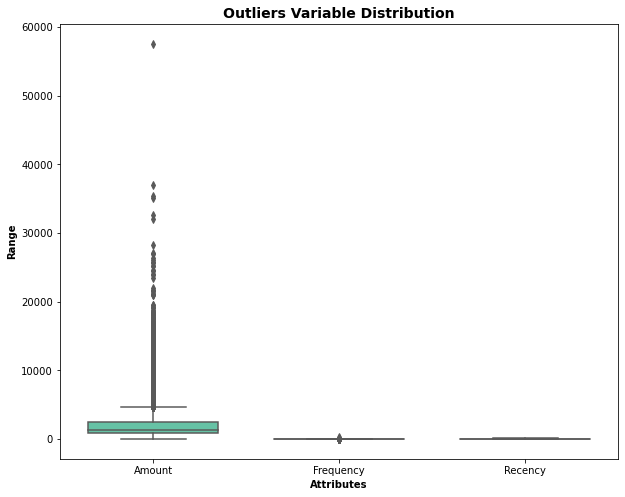

In [89]:

# Анализ выбросов

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [90]:
# Удаление выбросов для Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Удаление выбросов Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Удаление выбросов для Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

### Изменение масштаба атрибутов
 важно изменить масштаб переменных, чтобы они имели сопоставимый масштаб. Есть два распространенных способа изменения масштаба:

- Минимакс масштабирование
- Стандартизация (среднее-0, сигма-1)
Будем использовать стандартизацию.
Цель — преобразовать исходный набор в новый со средним значением равным 0 и стандартным отклонением равным 1.

In [91]:


# Изменение масштаба

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]


scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(48714, 3)

In [20]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.197192,0.038704,-1.242548
1,1.269266,0.675028,-1.421965
2,1.259530,1.947676,-1.493732
3,-0.778299,-0.597620,1.592238
4,2.388277,1.947676,-1.314315


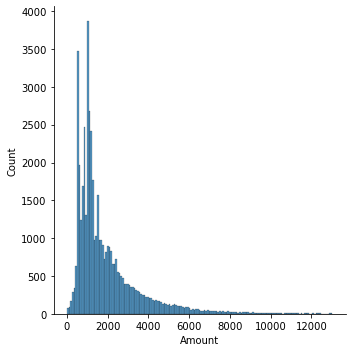

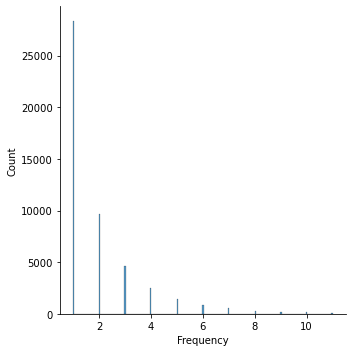

In [117]:

#fig, axes = plt.subplot(1,3, figsize=(20,5))
#for i, feature in enumerate(list(rfm.columns)):
sns.displot(rfm_df.Amount)
sns.displot(rfm_df.Frequency)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

# Шаг 4: Создание моделей 
# K-Means кластеризация

Алгоритм работает следующим образом:
Сначала мы случайным образом выбираем k точек
Мы классифицируем каждый элемент по ближайшему среднему значению и обновляем координаты среднего значения, которые представляют собой средние значения элементов, отнесенных к этому среднему значению на данный момент.
Мы повторяем процесс для заданного количества итераций, и в конце получаем кластеры

In [110]:
# k-means 

kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

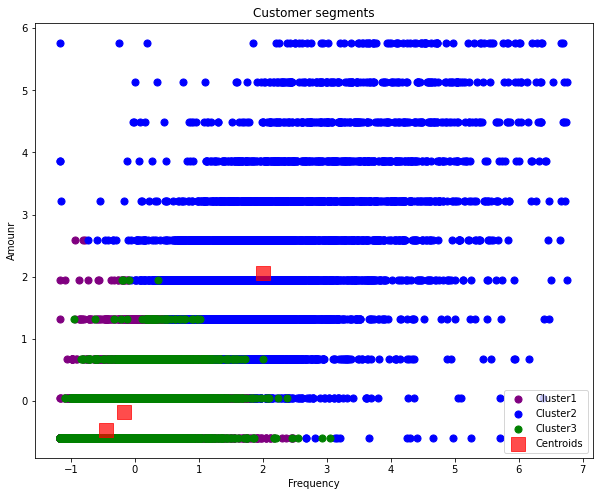

In [118]:
## k=3 визуалиация
km3=KMeans(n_clusters=3,init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = km4.fit_predict(rfm_df_scaled)
plt.scatter(rfm_df_scaled[y_means==0,0],rfm_df_scaled[y_means==0,1],s=50, c='purple',label='Cluster1')
plt.scatter(rfm_df_scaled[y_means==1,0],rfm_df_scaled[y_means==1,1],s=50, c='blue',label='Cluster2')
plt.scatter(rfm_df_scaled[y_means==2,0],rfm_df_scaled[y_means==2,1],s=50, c='green',label='Cluster3')
#plt.scatter(rfm_df_scaled[y_means==3,0],rfm_df_scaled[y_means==3,1],s=50, c='cyan',label='Cluster4')
plt.scatter(km4.cluster_centers_[:,0], km4.cluster_centers_[:,1],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
plt.title('Customer segments')
plt.xlabel('Frequency')
plt.ylabel('Amounr')
plt.legend()
plt.show()

In [22]:
kmeans.labels_

array([0, 3, 3, ..., 3, 3, 1])

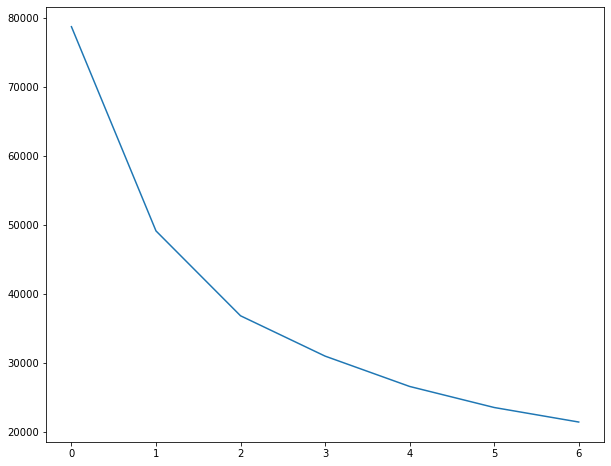

In [23]:
# Нахождение оптимального количества кластеров

# Метод локтя является эвристическим используемым в определении количества кластеров в наборе данных.
# Метод состоит из построения объясненного изменения как функции количества кластеров и выбора изгиба кривой
# в качестве количества используемых кластеров

# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$
* Силуэт относится к методу интерпретации и проверки согласованности в пределах кластеров данных . Этот метод дает краткое графическое представление о том, насколько хорошо каждый объект был классифицирован. Значение силуэта является мерой того, насколько объект похож на его собственный кластер (сцепление) по сравнению с другими кластерами (разделение). Силуэт находится в диапазоне от -1 до +1, где высокое значение указывает, что объект хорошо соответствует своему собственному кластеру и плохо соответствует соседним кластерам. Если большинство объектов имеют высокое значение, то конфигурация кластеризации подходит. Если многие точки имеют низкое или отрицательное значение, то в конфигурации кластеризации может быть слишком много или слишком мало кластеров. Силуэт можно рассчитать с помощью любой метрики расстояния , такой как евклидово расстояние или манхэттенское расстояние

In [149]:
## Silhouette analysis
# https://gdcoder.com/silhouette-analysis-vs-elbow-method-vs-davies-bouldin-index-selecting-the-optimal-number-of-clusters-for-kmeans-clustering/

# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.5189715338416448
For n_clusters=3, the silhouette score is 0.41373399614329975
For n_clusters=4, the silhouette score is 0.41208414045294434
For n_clusters=5, the silhouette score is 0.3541994280657738
For n_clusters=6, the silhouette score is 0.35118401070444505
For n_clusters=7, the silhouette score is 0.35570126857206275
For n_clusters=8, the silhouette score is 0.35474548123427635


In [24]:
# модель с  k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)


KMeans(max_iter=50, n_clusters=3)

In [25]:
 kmeans.labels_

array([2, 1, 1, ..., 2, 2, 0])

In [26]:

rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,1000037.0,1600.0,2,7,2
1,1000052.0,4010.0,3,2,1
2,100008.0,3994.0,5,0,1
3,1000093.0,645.0,1,86,0
4,1000143.0,5849.0,5,5,1


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

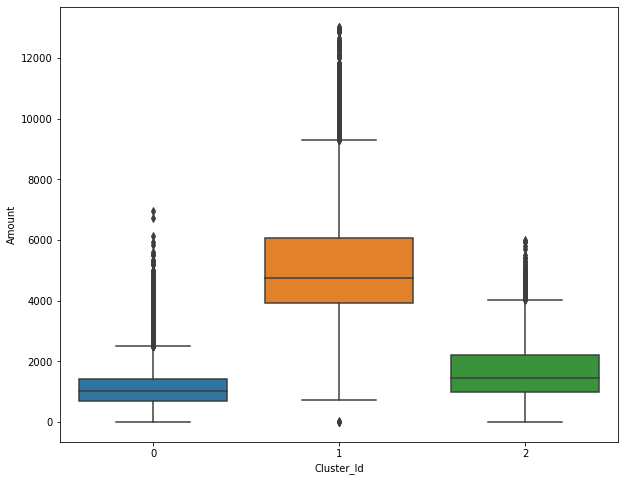

In [27]:
# Box plot для визуализации Cluster Id vs Amount

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

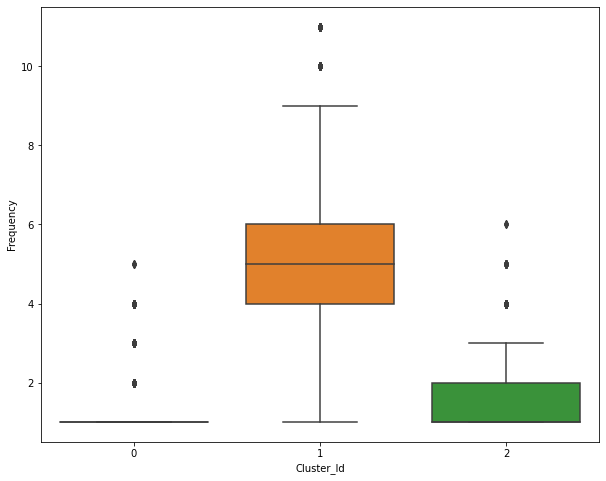

In [28]:
# Box plot для визуализации Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

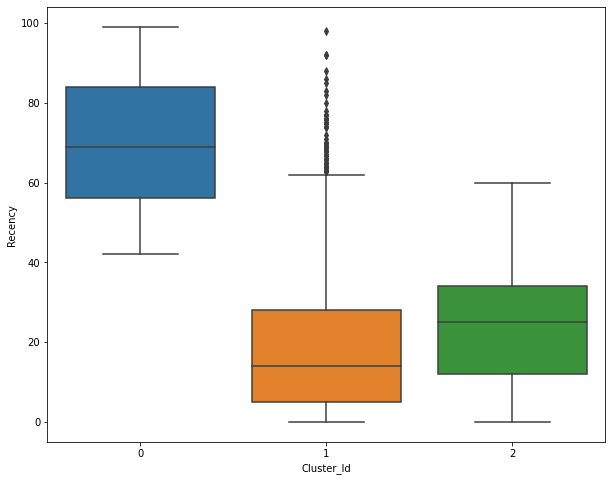

In [29]:
# Box plot для визуализации Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

In [41]:
 
#filter rows of original data cluster_labels
label = kmeans.fit(rfm_df_scaled)
filtered_label0 = rfm[ label == 0]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.show()
plt.show()

KeyError: False

### Иерархическая кластеризация

Иерархическая кластеризация включает создание кластеров, которые имеют заранее определенный порядок сверху вниз. Например, все файлы и папки на жестком диске организованы в иерархию. Есть два типа иерархической кластеризации:
- Разделительный
- Агломеративный

**Single Linkage:<br>**

1.	Одиночная связь (расстояния ближайшего соседа)
В этом методе расстояние между двумя кластерами определяется расстоянием между двумя наиболее близкими объектами (ближайшими соседями) в различных кластерах. Результирующие кластеры имеют тенденцию объединяться в цепочки.



![](https://www.saedsayad.com/images/Clustering_single.png)

In [30]:
## Single linkage: 

mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

KeyboardInterrupt: 

**Complete Linkage<br>**

2.	Полная связь (расстояние наиболее удаленных соседей)
В этом методе расстояния между кластерами определяются наибольшим расстоянием между любыми двумя объектами в различных кластерах (т.е. наиболее удаленными соседями). Этот метод обычно работает очень хорошо, когда объекты происходят из отдельных групп. Если же кластеры имеют удлиненную форму или их естественный тип является «цепочечным», то этот метод непригоден.



![](https://www.saedsayad.com/images/Clustering_complete.png)

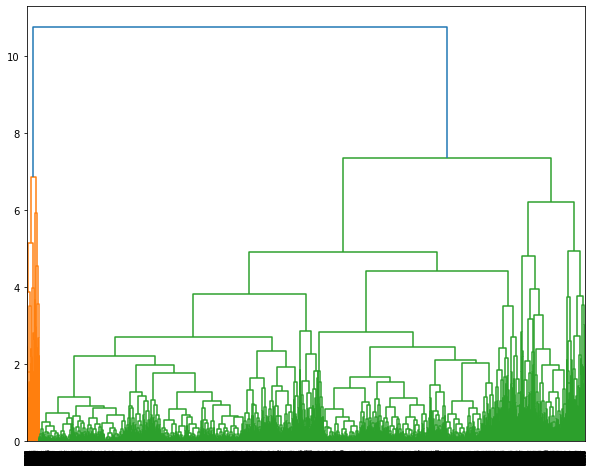

In [62]:
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

**Average Linkage:<br>**

Метод средней связи (average linkage) действует аналогично. Однако в этом методе рас­стояние между двумя кластерами определяют как среднее значение всех расстояний, изме->енных между объектами двух кластеров, при этом в каждую пару входят объекты из разных сластеров  в различных кластерах. Результирующие кластеры имеют тенденцию объединяться в цепочки.
nt in one cluster to every point in the other cluster. For example, the distance between clusters “r” and “s” to the left is equal to the average length each arrow between connecting the points of one cluster to the other.
![](https://www.saedsayad.com/images/Clustering_average.png)


In [ ]:
# Average linkage


mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

In [29]:
# Cutting the Dendrogram based on K
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

NameError: name 'mergings' is not defined

In [64]:


rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,100008,3598.0,4,5,0,0
1,1000143,4032.0,2,42,2,1
2,1000327,2143.0,2,26,0,1
3,1001069,4184.0,3,17,0,1
4,1001116,4902.0,4,12,0,1


<AxesSubplot:xlabel='Cluster_Labels', ylabel='Amount'>

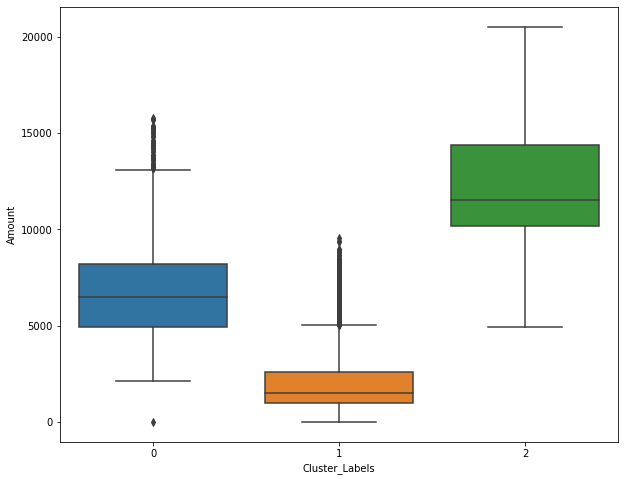

In [65]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Frequency'>

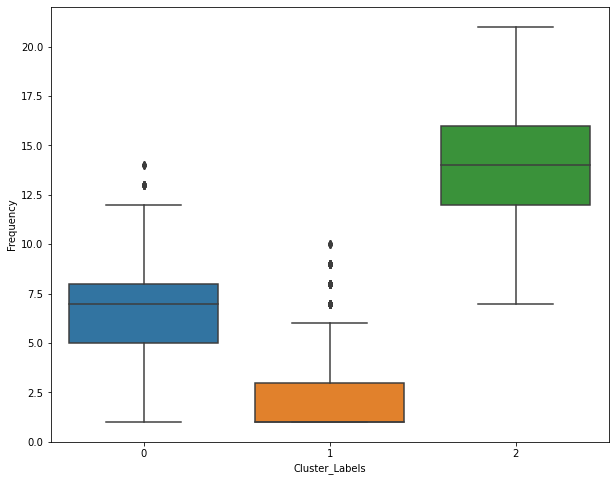

In [66]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Recency'>

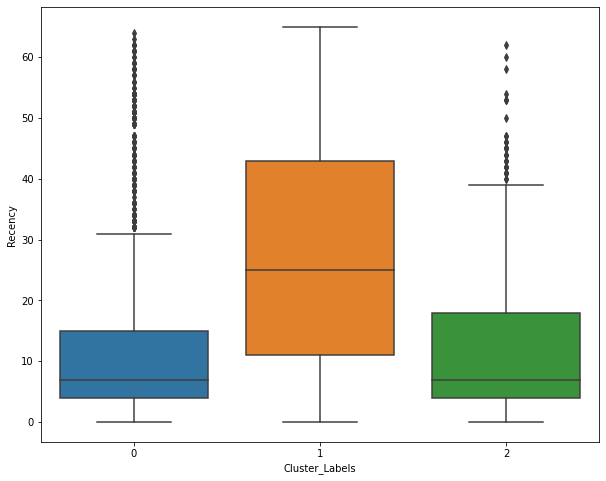

In [67]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

Тут будет вывод 


In [70]:

rfm.to_csv(writer,'AR')
writer.save()

NameError: name 'csv' is not defined